In [2]:
import gurobipy as gp
from gurobipy import GRB
import matplotlib.pyplot as plt
import math
import numpy as np
import pandas as pd
from IPython.display import Image
import pickle
import matplotlib.colors as colors
from mycolorpy import colorlist as mcp

In [3]:
from matplotlib.colors import ListedColormap
from matplotlib.colorbar import ColorbarBase

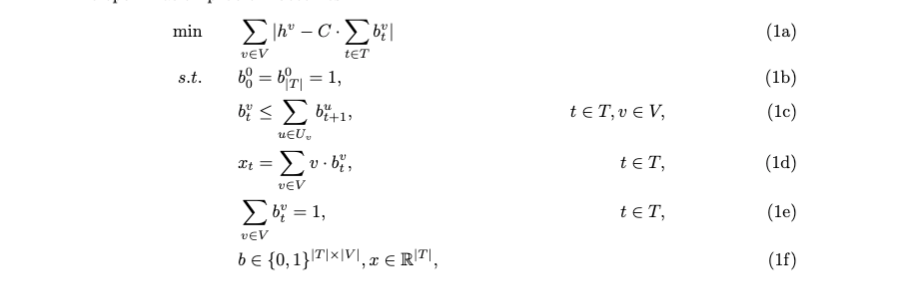

In [4]:
display(Image(filename='plots/obj_fun_accel.png'))

# Pick the data
The one being used RN is the Montreal data. Smoothed according to rolling mean (n=5) and bin-size = 0.1

In [5]:
#OG = pd.read_csv('gm_histo_clean.csv')
#OG = pd.read_csv("gm_clean_may14.csv")
OG = pd.read_csv("gm_clean_june4.csv")
#OG.drop(columns=["t", "id_origine"], inplace=True)

In [6]:
OG.drop(columns=["Unnamed: 0"], inplace=True)

OG.head(2)

,vel,acc
0,2.292727,-0.000000
1,2.292727,3.573622


Velocity bins
* distribute the velocities in the bin-sizes you want for a histogram
* figure out which of the bins corresponds to the mean velocity

In [7]:
variable = "vel"  
grouped_variable_name = "vel_bin"

bin_size = 0.4 #[m/s]
max_vel = 20 #[m/s]

vel = []
bin_labels = []
for i in range(int(max_vel/bin_size)):
    vel.append(round((i+1)*bin_size,2))
    bin_labels.append(i)

bin_edges = [0] + vel   
OG[grouped_variable_name] = pd.cut(
    OG[variable],
    bins=bin_edges,
    labels=bin_labels,
    right=True)  # Wheter to include the right edge in group or not

H = OG.groupby("vel_bin",observed=True)["vel_bin"].count().tolist()
#print("H =", H)
#print("vel =", vel)

In [8]:
OG.head(3)

,vel,acc,vel_bin
0,2.292727,-0.000000,5
1,2.292727,3.573622,5
2,6.479299,2.792294,16


In [9]:
mean_vel = OG["vel"].mean()
for i in range(1,len(bin_edges)):
    if mean_vel >= bin_edges[i-1]:
        if mean_vel <= bin_edges[i]:
            mean_idx = bin_labels[i-1]

In [10]:
mean_idx

13

Acceleration:
* Select Q, to generate q and A
* A = set of accelerations
* da = acc bin size
* q[a] percentage of time spent at this acceleration

In [11]:
#Choose q
#Q = [0.25, 0.5, 0.75, 0.98]
Q = [0.1, 0.3, 0.5, 0.7, 0.9, 0.99]
#Q= [0,0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
frame = OG.loc[OG["acc"]>0]
dec_frame = OG.loc[OG["acc"]<0]
plot1 = True
plot2 = False

A = []
for i in range(len(Q)):
    q = Q[i]
    accc = round(frame.groupby("vel_bin",observed=True)["acc"].apply(lambda x: x.quantile(q))[mean_idx],2)
    A.append(accc)
q = Q
q[-1] = 1

In [12]:
q_tf = []
for j in range(len(q)):
    if j == 0:
        q_tf.append(q[j]-0)
    else:
        q_tf.append(q[j]-q[j-1])

q = [round(x,2) for x in q_tf]

In [13]:
print("q = ", q, "\nA = ", A)

q =  [0.1, 0.2, 0.2, 0.2, 0.2, 0.1] 
A =  [0.02, 0.06, 0.11, 0.2, 0.42, 1.01]


And we want to scale H s.t. it adds up to T

In [63]:
dt = 4 #[s]; time step; divisible by 60; (dt | 60)
cycle_length = 25 #[min]; length of cycle
T = cycle_length*60/dt #total number of time steps
if T == np.round(T):
    T = int(T)
else:
    print("T not divisible by dt")
c = sum(H)/T
H = [x/c for x in H]

Start with opt model

In [64]:
J = len(A)
I = len(vel) #Python starts from zero

J_idx = [j for j in range(J)] # acc j = [1,2...,J]
T_idx = [t for t in range(T)] # timesteps t = [1,2,...,T]
Ta_idx = T_idx[0:-1]
I_idx = [i for i in range(I)] # vel i = [1,2,...,I]

M_v = vel[-1] + 1 # max vel

ti_pair = [(t,i) for t in T_idx for i in I_idx] # time-vel pair
tj_pair = [(t,j) for t in Ta_idx for j in J_idx] # time-acc pair

RedgeV_ti = {} # Set the right hand bin-edges for velocity bins
for k in range(len(ti_pair)):
    RedgeV_ti.update({ti_pair[k]: vel[ti_pair[k][1]]}) 

LedgeV_ti = {} # Set the left hand bin-edges for velocity bins
for k in range(len(ti_pair)):
    if k%I == 0:
        LedgeV_ti.update({ti_pair[k]: 0})  
    else:
        LedgeV_ti.update({ti_pair[k]: vel[ti_pair[k-1][1]]}) 


RedgeA_tj = {} # Set the right hand bin-edges for accel bins
for k in range(len(tj_pair)):
    RedgeA_tj.update({tj_pair[k]: A[tj_pair[k][1]]}) 

LedgeA_tj = {} # Set the left hand bin-edges for accel bins
for k in range(len(tj_pair)):
    if k%J == 0:
        LedgeA_tj.update({tj_pair[k]: 0})  
    else:
        LedgeA_tj.update({tj_pair[k]: A[tj_pair[k-1][1]]}) 


# Below we basically convert q[j]: the percentage of time spent in accel-mode A[j]
# To the corresponding # of timesteps we should spend in accel-mode A[j]
# epsilon offers a relaxation of that
epsilon = 0.2
leftQ = [max(0,np.floor((T-1)*(1-epsilon)*j)) for j in q]
rightQ = [np.ceil((T-1)*(1+epsilon)*j) for j in q]
#    m.addConstrs((g.sum("*",j) >= (T-1)*q[j]*(1-epsilon) for j in J_idx), "minQuant")
#    m.addConstrs((g.sum("*",j) <= (T-1)*q[j]*(1+epsilon) for j in J_idx), "minQuant")

slack = round(bin_size/4,2)

V_mid = [round(v-bin_size/2,1) for v in vel]
V_low = [round(v-slack,2) for v in V_mid]
V_high = [round(v + slack,2) for v in V_mid]

low_coeff = {}
high_coeff = {}
for k in range(len(ti_pair)):
    low_coeff.update({ti_pair[k]: V_low[ti_pair[k][1]]}) 
    high_coeff.update({ti_pair[k]: V_high[ti_pair[k][1]]}) 

Below all parameters for new constraints "stoppage" are added

In [65]:
Ns = 5 #[1] number of stops
s_lim = 2 #[m/s] all vel below s_lim are considered "stoppage"
s_av = 13 #[s] average length of stoppage (not used)

Ts = np.floor(Ns*s_av/dt) #[1] number of time-steps that should be "stoppage" (not used)
sigma_s = np.floor(Ts/10) # [1] lax in Ts (p/m 10%) (taken out of my ass) (not used)

#Create set for "stoppage"-velocities
V_s = []
Vs_idx = []
for i in range(len(vel)):
    if vel[i] < s_lim:
        V_s.append(vel[i])
        Vs_idx.append(I_idx[i])


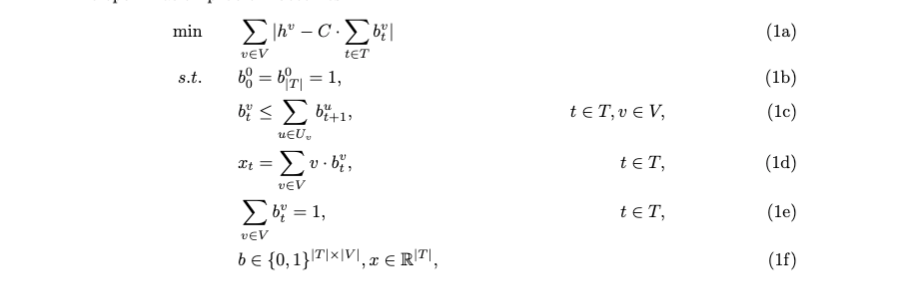

In [66]:
display(Image(filename='plots/obj_fun_accel.png'))

In [67]:
#model
try:
    m = gp.Model("DF")
    
    ###Variables:
    
    b = m.addVars(ti_pair, vtype=GRB.BINARY, name="b") #b(t,i) binary variables (if = 1; choose velocity "vel[i]" at time "t")
    x = m.addVars(T_idx, name="x") #velocity at time t 
    d = m.addVars(T_idx, vtype=GRB.BINARY, name="d") #d(t) binary variables (if = 1; we are entering or leaving z stop-period at time t
    c = m.addVars(tj_pair, vtype=GRB.BINARY, name="c")
    z = m.addVars(Ta_idx, name="z") #acceleration between time t and t+1 (hence different idx) 
    
    
    sumBinV = m.addVars(T_idx, name="sumBinV")   #sumBinV(t) = sum(b(t,v) for v in Vs)
    diffB = m.addVars(T_idx, lb = -1, name="diffB")
    sumBinU = m.addVars(ti_pair, name="sumBinU") #Helper function to constraint (c) 
                                                 #sumBinU[t,i] = sum(j in U_i, b(t,j))
    
    
    diffX = m.addVars(Ta_idx, lb = -M_v, name="diffX")
    absX = m.addVars(Ta_idx, name="absX")
    
    # diff, u and obj together corresponds to (a) - the objective function:
    diffObj = m.addVars(I_idx, lb = -T/10, name="diffObj") #diffObj(i) = h(i) - C*sum(t, b(t,i)) - see constraint "defDiff"
    absObj = m.addVars(I_idx, name="absObj")              #absObj(i) = abs(diff(i)) - see constraint "absDiff"
    obj = sum(absObj[i] for i in I_idx)                   #objective = sum(i, absObj(i))
    
    
    ###Model
    
    #Objective function (a)
    m.setObjective(obj, GRB.MINIMIZE)
    
    #constraints that help define the variables u(v) in the objective function:
    m.addConstrs((diffObj[i] == H[i] - b.sum("*",i) for i in I_idx), "DiffObj")
    m.addConstrs((absObj[i] == gp.abs_(diffObj[i]) for i in I_idx), "AbsObj")
    
    
    #constraint (b);    
    m.addConstr((b[0, 0] == 1), "StartB")  # initial speed = vel[0]
    m.addConstr((b[T - 1, 0] == 1), "EndB")  # final speed = vel[0]

    m.addConstrs((b.prod(LedgeV_ti,t,"*") <= x[t] for t in T_idx), "LeftVelEdge") #set speed for time t
    m.addConstrs((b.prod(RedgeV_ti,t,"*") >= x[t] for t in T_idx), "RightVelEdge") #set speed for time t
    
    

    #m.addConstrs((b.prod(LedgeV_ti,t,"*") + 0.01 <= x[t] for t in T_idx), "LeftVelEdge") #set speed for time t
    #m.addConstrs((b.prod(RedgeV_ti,t,"*") >= x[t] for t in T_idx), "RightVelEdge") #set speed for time t


    #constraint (e);
    m.addConstrs((b.sum(t,"*") == 1 for t in T_idx), "TotB") #keep tack of binary variables
    

    #constraint ? NEW (stoppage)
    
    #sumBinV[t] = 1 if we are IN Vs at time t
    m.addConstrs((gp.quicksum(b[t,v] for v in Vs_idx) == sumBinV[t] for t in T_idx), name = "SumBinV")

        
    m.addConstrs((diffB[t] == sumBinV[t] - sumBinV[t+1] for t in T_idx[0:-1]), name= "DiffB")
    m.addConstr((diffB[T-1] == 0), name="DiffB_") #last one is zero because we will not move in the next time-step


    # d constraint in subsec "Stops"
    m.addConstrs((d[t] == gp.abs_(diffB[t]) for t in T_idx), "AssD")
    m.addConstr((d.sum("*") == 2*(Ns + 1)), "TotD") #ensure Ns distinct stops


    
    # constraint NEW (cruising)
        
    m.addConstrs((diffX[t] == x[t] - x[t+1] for t in Ta_idx), name= "DiffX")
    m.addConstrs((absX[t] == gp.abs_(diffX[t]) for t in Ta_idx), name="AbsX")
    
    m.addConstrs((z[t] == absX[t]/dt for t in Ta_idx), name="Z")
    
    
    m.addConstrs((c.prod(LedgeA_tj,t,"*") + 0.001 <= z[t] for t in Ta_idx), "LeftAccEdge") #set vel for time t
    m.addConstrs((c.prod(RedgeA_tj,t,"*") >= z[t] for t in Ta_idx), "RightAccEdge") #set vel for time t

    m.addConstrs((c.sum(t,"*") == 1 for t in Ta_idx), "TotG") #keep tack of binary variables
    
    m.addConstrs((c.sum("*",j) >= leftQ[j] for j in J_idx), "minQuant")
    m.addConstrs((c.sum("*",j) <= rightQ[j] for j in J_idx), "minQuant")
    
    
    m.optimize()
    #for v in m.getVars():
    #    print('%s %g' % (v.VarName, v.X))
    
    print('Obj: %g' % m.ObjVal)

except gp.GurobiError as e:
    print('Error code ' + str(e.errno) + ': ' + str(e))

except AttributeError:
    print('Encountered an attribute error')


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.5.0 23F79)

CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 3810 rows, 42466 columns and 92264 nonzeros
Model fingerprint: 0x7432e68e
Model has 799 general constraints
Variable types: 21097 continuous, 21369 integer (21369 binary)
Coefficient statistics:
  Matrix range     [2e-02, 2e+01]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 4e+01]
  RHS range        [1e-03, 9e+01]
Presolve added 2051 rows and 0 columns
Presolve removed 0 rows and 17805 columns
Presolve time: 0.15s
Presolved: 5861 rows, 24661 columns, 96475 nonzeros
Variable types: 1597 continuous, 23064 integer (21945 binary)

Root relaxation: objective 0.000000e+00, 5960 iterations, 0.40 seconds (0.77 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0 

In [68]:
m.Runtime/3600

0.08909800416893429

In [69]:
lr = m.getAttr("X", x)
dft = pd.DataFrame()
dft["vel"] = list(lr.values())
dft["t"] = dt
acc_list = list(m.getAttr("X", z).values())
dft["a"] = acc_list + [0]
dft["timesum"] = dft["t"].cumsum()

In [77]:
variable = "a"  
grouped_variable_name1 = "c_color"
grouped_variable_name2 = "c_viridis"


bin_edges = [-0.2] + A
kk = 20
color1 = ["tab:green", "tab:red", "tab:blue", "tab:purple", "tab:orange", "tab:grey"]#[x/5 for x in range(6)]
color2 = mcp.gen_color(cmap="viridis",n=6*kk+1)
color2 = [color2[kk*i] for i in range(6)]

dft[grouped_variable_name1] = pd.cut(
    dft[variable],
    bins=bin_edges,
    labels=color1,
    right=True)  # Wheter to include the right edge in group or not

dft[grouped_variable_name2] = pd.cut(
    dft[variable],
    bins=bin_edges,
    labels=color2,
    right=True)  # Wheter to include the right edge in group or not

In [78]:
color2

['#440154', '#443983', '#31688e', '#21918c', '#35b779', '#90d743']

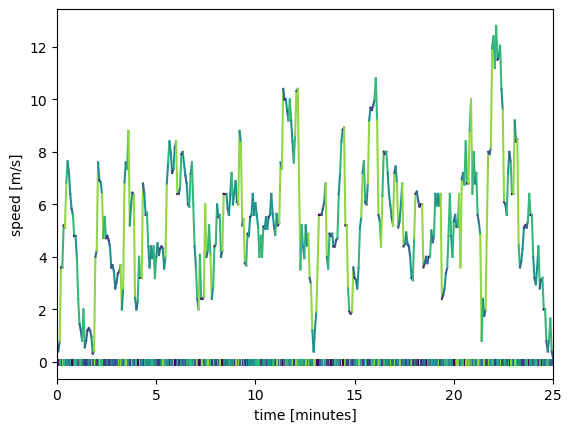

In [79]:
fig, ax = plt.subplots(1)
#ax.plot(dft["timesum"]/60,dft["vel"])
#ax.scatter(dft["timesum"]/60,dft["vel"], c = dft["acc"], cmap=cmap)
color_map = "c_viridis"#"c_color" #"c_viridis" #
col_list = {"c_viridis":color2, "c_color":color1}
lab_list = [0.1, 0.3, 0.5, 0.7, 0.9, 0.99]

lab_dic = {}
for idx, col in enumerate(col_list[color_map]):
    lab_dic[col] = lab_list[idx]

for i in range(len(dft)-1):
    color = dft[color_map][i]
    if lab_dic[color] != 0:
        ax.plot([dft["timesum"][i]/60, dft["timesum"][i+1]/60], [dft["vel"][i], dft["vel"][i+1]], c = color, label=lab_dic[color])
        lab_dic[color] = 0
    else:
        ax.plot([dft["timesum"][i]/60, dft["timesum"][i+1]/60], [dft["vel"][i], dft["vel"][i+1]], c = color)#cmap(dft["a_bin"][i]))
    ax.plot([dft["timesum"][i]/60, dft["timesum"][i+1]/60], [0,0], c = color,linewidth=5)#cmap(dft["a_bin"][i]))
    
plt.xlabel("time [minutes]")
plt.ylabel("speed [m/s]")

handles, labels = plt.gca().get_legend_handles_labels()

# Sort handles and labels based on labels
sorted_labels, sorted_handles = zip(*sorted(zip(labels, handles), key=lambda t: t[0]))

#plt.legend(sorted_handles, sorted_labels, loc="upper right", fontsize="small")
#plt.legend(sorted_handles, sorted_labels, bbox_to_anchor=(0.83,0.0615), fontsize="small")
plt.xlim([0,25])
#plt.ylim([0,10])
#plt.colorbar()  # Add a colorbar


plt.savefig("cycle_5_color")
plt.show()

In [73]:
import matplotlib.patches as patchh


In [98]:
color_list[6]

IndexError: list index out of range

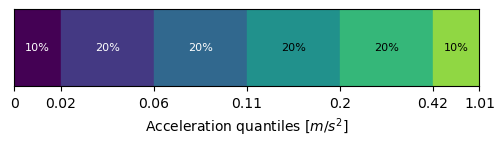

In [107]:
fig, ax = plt.subplots(figsize=(6, 1)) 



bounds = [0] + Q
color_list = col_list[color_map]
ytick_positions = bounds
A_lab = [0] + A
#A_lab[-1] = "   " + str(A_lab[-1])
#A_lab[1] = str(A_lab[1])
ytick_labels = A_lab# []
size_list = [10,20,20,20,20,10]
coco = ["w","w","w","k","k", "k"]

for i in range(len(bounds)-1):
    cc = color_list[i]
    lb = bounds[i]
    hight = bounds[i+1] - bounds[i]
    #ytick_positions.append(lb+hight/2)
    #lab = str(A_lab[i])+"-"+str(A_lab[i+1])
    #ytick_labels.append(lab)
    rect = patchh.Rectangle((lb, 0), hight, 2, color = cc)
    
    ax.add_patch(rect)
    x_pos = lb+hight/2
    name = str(size_list[i]) + "%"
    ax.annotate(name, (x_pos, 0.5), color=coco[i], 
                fontsize=8, ha='center', va='center')
    
ax.set_xticks(ytick_positions)
#ax.set_yticks([])
ax.set_xticklabels(ytick_labels)
ax.set_yticks([])
ax.set_xlabel(r'Acceleration quantiles $[m/s^2]$')
plt.savefig("horisontal_colorbar_acc_color", bbox_inches='tight')
plt.show()

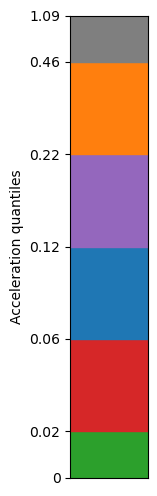

In [191]:
fig, ax = plt.subplots(figsize=(1, 6)) 

bounds = [0] + Q
color_list = col_list[color_map]
ytick_positions = bounds
ytick_labels =[0] + A
for i in range(len(bounds)-1):
    cc = color_list[i]
    lb = bounds[i]
    hight = bounds[i+1] - bounds[i]
#    ytick_positions.append(lb+hight/2)
    
    rect = patchh.Rectangle((0, lb), 2, hight, color = cc)
    ax.add_patch(rect)

ax.set_yticks(ytick_positions)
#ax.set_yticks([])
ax.set_yticklabels(ytick_labels)
ax.set_xticks([])
#plt.savefig('figure.png', bbox_inches='tight')
plt.savefig("vertical_colorbar_acc_color", bbox_inches='tight')
plt.show()

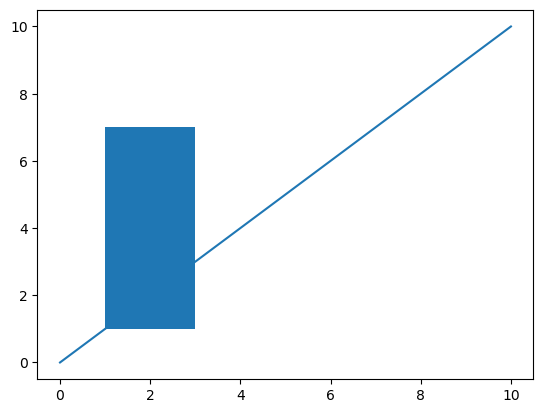

In [99]:
from matplotlib.patches import Rectangle

fig, ax = plt.subplots()

#create simple line plot
ax.plot([0, 10],[0, 10])

#add rectangle to plot
ax.add_patch(Rectangle((1, 1), 2, 6))

#display plot
plt.show()

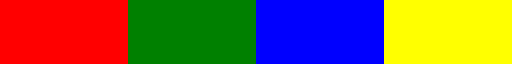

In [57]:
cmap

In [61]:
[x for x in range(5)]

[0, 1, 2, 3, 4]

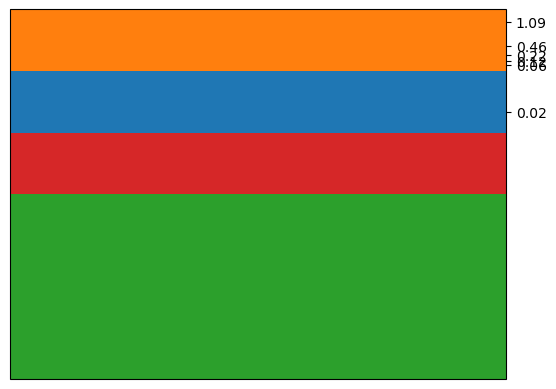

In [65]:
colors = color1
labels = A
boundaries = [-0.2] + A

# Create a custom colormap with the specified colors
cmap = ListedColormap(colors[:len(labels)])

# Create a figure and axis for the colorbar
fig, ax = plt.subplots()

# Create a colorbar with custom colors and labels
#boundaries = [x/len(labels) for x in range(len(labels) + 1)]
colorbar = ColorbarBase(ax=ax, cmap=cmap, ticks=[i + 0.5 for i in boundaries[:-1]], boundaries=boundaries, orientation='vertical')
colorbar.set_ticklabels(labels)

plt.show()


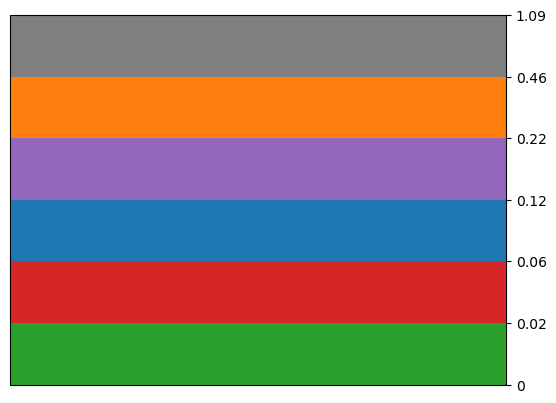

In [71]:
boundaries = [0] + A
colors = color1
labels = boundaries

# Create a custom colormap with the specified colors and boundaries
cmap = ListedColormap(colors)
norm = BoundaryNorm(boundaries, cmap.N)

# Create a figure and axis for the colorbar
fig, ax = plt.subplots()

# Create a colorbar with custom boundaries, colors, and labels
colorbar = ColorbarBase(ax=ax, cmap=cmap, norm=norm, ticks=boundaries, orientation='vertical')
colorbar.set_ticklabels(labels)

plt.show()

In [83]:
list(zip(normalized_boundaries, colors))

[(0, 'green'), (0.1, 'yellow'), (0.5, 'red')]

In [86]:
def plot_examples(colormaps):
    """
    Helper function to plot data with associated colormap.
    """
    np.random.seed(19680801)
    data = np.random.randn(30, 30)
    n = len(colormaps)
    fig, axs = plt.subplots(1, n, figsize=(n * 2 + 2, 3),
                            layout='constrained', squeeze=False)
    for [ax, cmap] in zip(axs.flat, colormaps):
        psm = ax.pcolormesh(data, cmap=cmap, rasterized=True, vmin=-4, vmax=4)
        fig.colorbar(psm, ax=ax)
    plt.show()

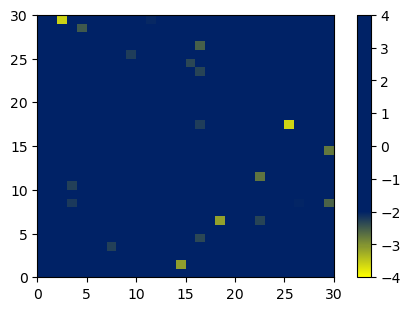

In [94]:
#nodes = [0.0, 0.4, 0.8, 1.0]
#cmap2 = LinearSegmentedColormap.from_list("mycmap", list(zip(nodes, colors)))

plot_examples([cmap])


In [92]:
cmap = LinearSegmentedColormap.from_list('custom blue', 
                                             [(0,    '#ffff00'),
                                              (0.25, '#002266'),
                                              (1,    '#002266')])

In [95]:
list(zip(nodes, colors))

[(0.0, 'green'), (0.4, 'yellow'), (0.8, 'red')]

In [81]:
colors = ['green', 'yellow', 'red']

# Define the boundaries for each segment
boundaries = [0, 0.1, 0.5, 1]

# Normalize the boundaries to be between 0 and 1
normalized_boundaries = [boundaries[0]] + [(x - boundaries[0]) / (boundaries[-1] - boundaries[0]) for x in boundaries[1:]]

# Create a colormap with specified colors and boundaries
cmap = LinearSegmentedColormap.from_list('custom_cmap', list(zip(normalized_boundaries, colors)))

# Plot a colorbar to visualize the colormap
plt.colorbar()#(plt.cm.ScalarMappable(cmap=cmap))
plt.show()

RuntimeError: No mappable was found to use for colorbar creation. First define a mappable such as an image (with imshow) or a contour set (with contourf).

<Figure size 640x480 with 0 Axes>

In [82]:
cmap

ValueError: data mapping points must start with x=0 and end with x=1

ValueError: data mapping points must start with x=0 and end with x=1

In [192]:
dft["a"] = abs(dft["a"])
variable = "a"  
grouped_variable_name = "a_bin"


bin_edges = [-0.1, 0.1, 0.3, 0.5, 0.7, 0.9, 1]
bin_labels = ["tab:green", "tab:red", "tab:blue", "tab:purple", "tab:orange", "tab:grey"]#[x/5 for x in range(6)]

dft[grouped_variable_name] = pd.cut(
    dft[variable],
    bins=bin_edges,
    labels=bin_labels,
    right=True)  # Wheter to include the right edge in group or not


In [193]:
dft

,vel,t,a,acc,timesum,col,a_bin
0,0.000,4,0.400,0.400,4,0.444444,tab:blue
1,1.600,4,0.300,0.300,8,0.333333,tab:red
2,2.800,4,0.380,0.380,12,0.422222,tab:blue
3,4.320,4,0.120,0.120,16,0.133333,tab:red
4,4.800,4,0.021,0.021,20,0.023333,tab:green
...,...,...,...,...,...,...,...
370,5.120,4,0.460,-0.460,1484,0.511111,tab:blue
371,3.280,4,0.541,-0.541,1488,0.601111,tab:purple
372,1.116,4,0.221,0.221,1492,0.245556,tab:red
373,2.000,4,0.460,-0.460,1496,0.511111,tab:blue


In [212]:
dft["v_tf"] = dft["vel"].shift(-1)
dft.fillna(0, inplace=True)

In [102]:
dft["acc"] = (dft["v_tf"]-dft["vel"])/dft["t"]
dft.drop("v_tf", axis=1, inplace=True)

In [103]:
dft["timesum"] = dft["t"].cumsum()

In [104]:
len(dft.loc[(dft["acc"]<0.1) & (dft["acc"]>-0.1)])/len(dft)

0.328

In [174]:
dft["col"] = abs(dft["acc"])
dft["col"] = dft["col"]/dft["col"].max()

In [175]:
print(A)

[0.02, 0.06, 0.12, 0.22, 0.46, 0.9]


In [ ]:
#colors = ['#FF5733', '#FFC300', '#85C1E9', '#3498DB', '#2E86C1']  # Example colors
#labels = ['Low', 'Medium Low', 'Medium', 'Medium High', 'High']

bounds = np.array([0, 0.1, 0.3, 0.5, 0.7, 0.9, 1])
labels = [""]
colors = ["tab:green", "tab:red", "tab:blue", "tab:purple", "tab:orange", "tab:grey"]
# Create a custom colormap with the specified colors
cmap = ListedColormap(colors)

# Create a plot with the custom colormap
plt.imshow(data, cmap=cmap)
plt.colorbar()  # Add a colorbar

# Create a custom colorbar with labels

norm = plt.Normalize(bounds.min(), bounds.max())
cbar = ColorbarBase(plt.gca().images[-1].colorbar, cmap=cmap, norm=norm, boundaries=bounds, ticks=bounds, spacing='proportional')
cbar.set_ticklabels(labels)


fig, ax = plt.subplots(1)
#ax.plot(dft["timesum"]/60,dft["vel"])
#ax.scatter(dft["timesum"]/60,dft["vel"], c = dft["acc"], cmap=cmap)
for i in range(len(dft)-1):
    ax.plot([dft["timesum"][i]/60, dft["timesum"][i+1]/60], [dft["vel"][i], dft["vel"][i+1]], c = dft["a_bin"][i])#cmap(dft["a_bin"][i]))

plt.xlabel("time [minutes]")
plt.ylabel("speed [m/s]")

plt.xlim([0,25])
#plt.ylim([0,10])
plt.colorbar()  # Add a colorbar

# Create a custom colorbar with labels
cbar = ColorbarBase(plt.gca().images[-1].colorbar, cmap=cmap, norm=norm, boundaries=bounds, ticks=bounds, spacing='proportional')
cbar.set_ticklabels(labels)

plt.savefig("multi_color_mid")
plt.show()

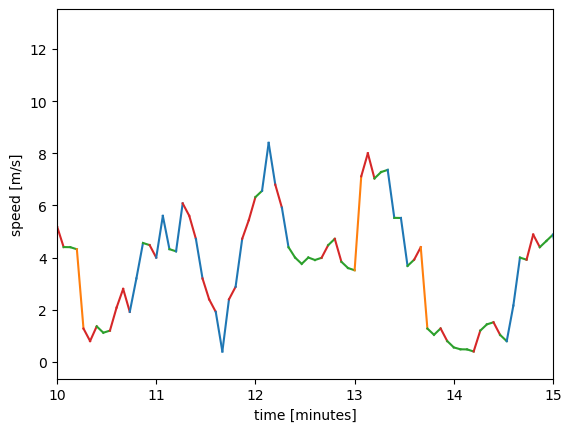

In [198]:
from matplotlib import colormaps as cmp
#cmap = cmp['viridis'] # Colour map (there are many others)
#cmap = cmp["Set1"]
#fig, ax = plt.subplots(1)
# Now here's the plot. range(len(df)) just makes the x values 1, 2, 3...
# df[0] is then the y values. c sets the colours (same as y values in this
# case). s is the marker size.
#ax.scatter(range(len(df)), df[0], c=df[0], s=120, cmap=cmap, edgecolor='None')

fig, ax = plt.subplots(1)
#ax.plot(dft["timesum"]/60,dft["vel"])
#ax.scatter(dft["timesum"]/60,dft["vel"], c = dft["acc"], cmap=cmap)
for i in range(len(dft)-1):
    ax.plot([dft["timesum"][i]/60, dft["timesum"][i+1]/60], [dft["vel"][i], dft["vel"][i+1]], c = dft["a_bin"][i])#cmap(dft["a_bin"][i]))

plt.xlabel("time [minutes]")
plt.ylabel("speed [m/s]")

plt.xlim([0,25])
#plt.ylim([0,10])
plt.colorbar()  # Add a colorbar

# Create a custom colorbar with labels
cbar = ColorbarBase(plt.gca().images[-1].colorbar, cmap=cmap, norm=norm, boundaries=bounds, ticks=bounds, spacing='proportional')
cbar.set_ticklabels(labels)

plt.savefig("multi_color_mid")
plt.show()

In [177]:
test = dft.copy()
test["mean_vel"] = test["vel"].rolling(5).mean()


test.dropna(inplace=True)
test["v_tf"] = test["mean_vel"].shift(-1)
#test["v_tf"] = test["v_tf"].fillna(0)
test.dropna(inplace=True)
test["acc"] = (test["v_tf"]-test["mean_vel"])/test["t"]
test.drop("v_tf", axis=1, inplace=True)
test["col"] = abs(test["acc"])
test["col"] = test["col"]/test["col"].max()

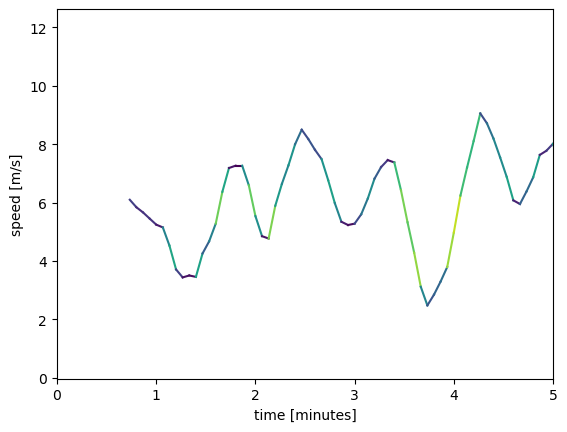

In [201]:
cmap = cmp['viridis']

fig, ax = plt.subplots(1)
#ax.plot(test["timesum"]/60,test["vel"])
#ax.scatter(test["timesum"]/60,test["vel"], c = test["acc"], cmap=cmap)
for i in range(10,len(test)-1):
    ax.plot([test["timesum"][i]/60, test["timesum"][i+1]/60], [test["mean_vel"][i], test["mean_vel"][i+1]], c = cmap(test["col"][i]))
    

plt.xlabel("time [minutes]")
plt.ylabel("speed [m/s]")

plt.xlim([0,5])
#plt.ylim([0,10])
plt.savefig("rolling5_5")
plt.show()

AttributeError: 'Colorbar' object has no attribute 'set_clim'

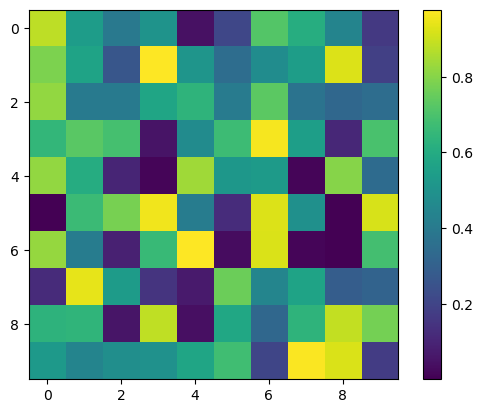

In [111]:
# Generate some sample data
data = np.random.rand(10, 10)

# Create a heatmap plot
plt.imshow(data, cmap='viridis')
plt.colorbar()  # Create a colorbar

# Get the current colorbar object
cbar = plt.gca().images[-1].colorbar

# Set the colorbar range
cbar.set_clim(0, 1)  # Set the range from 0 to 1

plt.show()


In [56]:
dft.drop(columns=["a","t", "pos_acc","neg_acc","idle","cruise","acc_time"],inplace=True)

In [59]:
dft.to_csv("OPT_trip.csv")

In [82]:
OG

,vel,acc,vel_bin,pos_acc,neg_acc,idle,cruise,acc_time
0,12.814298,-0.436593,32,NaN,-0.436593,0,0,0
1,12.302391,-1.501606,30,NaN,-1.501606,0,0,0
2,10.541754,-1.869684,26,NaN,-1.869684,0,0,0
3,8.349546,-1.588744,20,NaN,-1.588744,0,0,0
4,6.486741,-0.760610,16,NaN,-0.760610,0,0,0
...,...,...,...,...,...,...,...,...
4090469,5.692212,0.140623,14,0.140623,NaN,0,0,1
4090470,5.857093,0.028499,14,0.028499,NaN,0,1,0
4090471,5.890508,-0.092428,14,NaN,-0.092428,0,1,0
4090472,5.782137,-0.114894,14,NaN,-0.114894,0,0,0


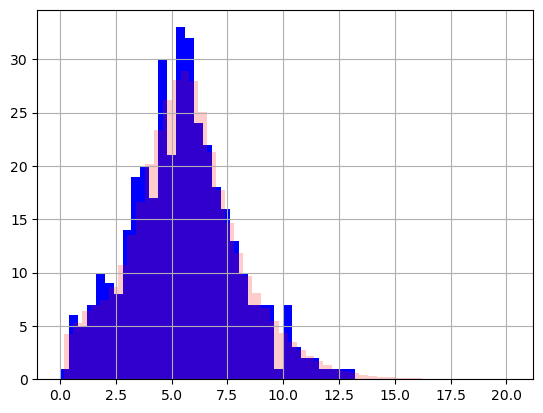

In [77]:
#H_dft = dft.groupby("vel_bin")["vel_bin"].count().tolist()

#plt.bar(vel, H_dft, width=0.2 )#[x/bin_size for x in dft[""]], , width=0.4, alpha=0.5)
bins = bin_edges
#bins = [x/10 for x in range(200)]

dft["vel"].hist(bins=bins,alpha=1, width=bin_size, color="b")
#dft["vel_bin"].hist(lr.values(), , width=0.4, alpha=0.5)
#plt.hist(lr.values(), bins=[x/10 for x in range(200)], width=0.1, alpha=0.5)
plt.bar(vel, H,alpha=0.2,width=bin_size, color="r")
#OG["vel"].hist(bins=bin_edges,alpha=0.5,color="r")
plt.show()

In [44]:
OG.head()

,vel,acc,vel_bin
0,12.814298,-0.436593,32
1,12.302391,-1.501606,30
2,10.541754,-1.869684,26
3,8.349546,-1.588744,20
4,6.486741,-0.760610,16


In [78]:
#create dataframe to keep track of unique values for all trips
dft_vals = pd.DataFrame(index=["OPT","OG"])
#add mean vel, mean acc, mean dec to each MT
dft_vals["vel_mean"] = [dft["vel"].mean(), OG["vel"].mean()]

dft["pos_acc"] = dft["acc"]
dft.loc[dft["pos_acc"] < 0 , "pos_acc"] = np.nan
OG["pos_acc"] = OG["acc"]
OG.loc[OG["pos_acc"] < 0 , "pos_acc"] = np.nan
dft_vals["acc_mean"] = [dft["pos_acc"].mean(), OG["pos_acc"].mean()]


dft["neg_acc"] = dft["acc"]
dft.loc[dft["neg_acc"] > 0 , "neg_acc"] = np.nan
OG["neg_acc"] = OG["acc"]
OG.loc[OG["neg_acc"] > 0 , "neg_acc"] = np.nan

dft_vals["dec_mean"] = [dft["neg_acc"].mean(),OG["neg_acc"].mean()]

dft["idle"] = 0
dft.loc[dft["vel"]<2, "idle"] = 1
OG["idle"] = 0
OG.loc[OG["vel"]<2, "idle"] = 1
#add percentage of time spent idling
dft_vals["idle"] = [dft["idle"].sum()/len(dft), OG["idle"].sum()/len(OG)]


#(dft["stop"]*dft["time"]).groupby(level=0).sum()/dft["duration"].mean()

#time spent cruising
cruise_lim = 0.1 #[m/s^2]

dft["cruise"] = 1
dft.loc[dft["acc"] < -cruise_lim , "cruise"] = 0
dft.loc[dft["acc"] > cruise_lim , "cruise"] = 0

OG["cruise"] = 1
OG.loc[OG["acc"] < -cruise_lim , "cruise"] = 0
OG.loc[OG["acc"] > cruise_lim , "cruise"] = 0

dft_vals["cruise"] = [dft["cruise"].sum()/len(dft), OG["cruise"].sum()/len(OG)]

#time spent accelerating
cruise_lim = 0.1 #[m/s^2]

dft["acc_time"] = 1
dft.loc[dft["acc"] < cruise_lim , "acc_time"] = 0
OG["acc_time"] = 1
OG.loc[OG["acc"] < cruise_lim , "acc_time"] = 0

dft_vals["acc_time"] = [dft["acc_time"].sum()/len(dft), OG["acc_time"].sum()/len(OG)]

dft_vals["vel_max"] = [dft["vel"].max(), OG["vel"].quantile(0.99)]
dft_vals["acc_max"] = [dft["acc"].max(), OG["pos_acc"].quantile(0.99)]
dft_vals["dec_min"] = [dft["acc"].min(), OG["neg_acc"].quantile(0.01)]

for col in dft_vals.columns:
    dft_vals[col] = [round(x,2) for x in dft_vals[col].tolist()]
#if no accel/decel takes place during a trip, this would be set to NaN, so here we just set those to zero

In [79]:
dft_vals

,vel_mean,acc_mean,dec_mean,idle,cruise,acc_time,vel_max,acc_max,dec_min
OPT,5.39,0.24,-0.25,0.08,0.34,0.33,12.80,1.07,-1.07
OG,5.43,0.22,-0.21,0.08,0.39,0.28,12.19,1.11,-1.06


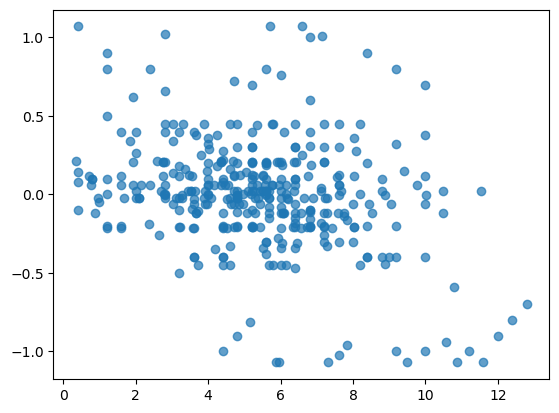

In [80]:
plt.scatter(dft["vel"], dft["acc"],alpha=0.7)

In [102]:
(0.8-1.322)/2

-0.261

In [101]:
dft

,vel,acc,timesum,pos_acc,neg_acc,idle,cruise,acc_time
0,0.400,1.000,2,1.000,NaN,1,0,1
1,2.400,0.800,4,0.800,NaN,0,0,1
2,4.000,1.070,6,1.070,NaN,0,0,1
3,6.140,0.130,8,0.130,NaN,0,0,1
4,6.400,-0.400,10,NaN,-0.400,0,0,0
...,...,...,...,...,...,...,...,...
745,0.800,0.200,1492,0.200,NaN,1,0,1
746,1.200,0.061,1494,0.061,NaN,1,1,0
747,1.322,-0.261,1496,NaN,-0.261,1,0,0
748,0.800,-0.200,1498,NaN,-0.200,1,0,0


In [454]:
dft.to_csv("first_test_const2.csv")

In [53]:
#print(list(lr.values()))
under_2 = 0

for el in list(lr.values()):
    if el < 2:
        under_2 += 1
        
print("we spend" , under_2/len(lr.values()), "% of the time below 2m/s")

we spend 0.084 % of the time below 2m/s


In [436]:
check = m.getAttr("X", help_diff_Vs)
#print(check.values()

In [437]:
 # Print number of solutions stored
nSolutions = m.SolCount
print('Number of solutions found: ' + str(nSolutions))
# Print objective values of solutions
print("w/ resp. obj val:")
for idx in range(nSolutions):
    m.setParam(GRB.Param.SolutionNumber, idx)
    print('%g ' % m.PoolObjVal, end='')

num_to_plot = 3
print("We ")
    
x_list = []
for idx in range(3):
    m.setParam(GRB.Param.SolutionNumber, idx)
    curr_x = m.getAttr("Xn", x)
    
    x_list.append(curr_x)

Number of solutions found: 3
w/ resp. obj val:
22.11 37.4639 67.6437 We 


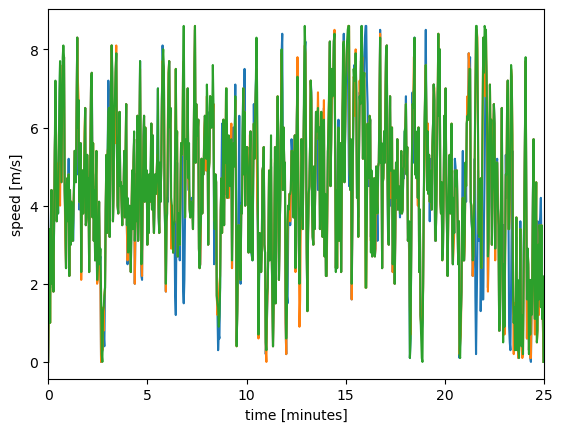

In [438]:
#fig = plt.figure(figsize=(25, 5))
plt_idx = 0

for lr in x_list:
    plt_idx += 1
    #plt.subplot(1,3,plt_idx) #uncomment if you want to plot in separate windows
    plt.plot([k*dt/60 for k in list(lr.keys())],list(lr.values()))
    plt.xlabel("time [minutes]")
    plt.ylabel("speed [m/s]")

    plt.xlim([0,25])
plt.show()

Save the velocity vector for top 3 obj vals

In [439]:
run_name = "OPT_data" #this took 1343 seconds
x_dic = {}

for idx in range(3):
    m.setParam(GRB.Param.SolutionNumber, idx)
    curr_x = list(m.getAttr("Xn", x).values())
    curr_x = [m.PoolObjVal] + curr_x
    x_dic[idx] = curr_x

with open(run_name+".pickle", 'wb') as handle:
    pickle.dump(x_dic, handle, protocol=pickle.HIGHEST_PROTOCOL)

* "OPT_physics": OG data, cut of at 8.7 m/s (due to acceleration limitations), no forcing of total length of stops, the number of stops set to 31. Physics formulation of (max) acceleration used.

* "OPT_constant": OG data, cut of at 8.7 m/s (to make comparison possible), no forcing of total length of stops, the number of stops set to 31. A constant (max) acceleration used (0.71 m/s^2 from litterature)

* "OPT_data": OG data, cut of at 8.7 m/s (to make comparison possible), no forcing of total length of stops, the number of stops set to 31. (max) acceleration based on 70% quantile of acceleration in OG data.




* "phys_wStops_" took 1343 seconds; it uses the physics-acceleration, and the new constraints re; stoppage is included. In it we spend 0.084 % of the time below 2m/s

* "phys_noStops_" took 1200 seconds; it uses the physics-acceleration, but is not forced to stop. In it we spend 0.136 % of the time below 2m/s

* "const_wStops_OG" 

* "const_wStops_smooth"

* "const_cut_87_OG" no vel over 8.7 m/s

* "dist_cut_87_OG"

* "phys_wStops_OG"

In [145]:
runs = ["phys_wStops", "phys_noStops","const_wStops_OG", "const_wStops_smooth"]

name = runs[1] #choose one

with open(name+".pickle", 'rb') as handle: #open
    x_val_dic = pickle.load(handle)

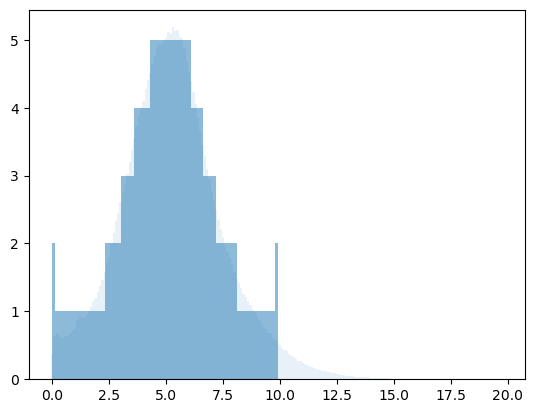

In [79]:


plt.hist(lr.values(), bins=[x/10 for x in range(100)], width=0.1, alpha=0.5)
plt.bar(vel, H,alpha=0.1,width=0.1)
plt.show()


In [58]:
#500 sek dt 10
#1699 for 8 dt
#dt 6 3310
#old dt4 300
#old dt2 3000

list

In [24]:
model_dic = {}
obj_dic = {}
x_dic = {}

key = "j"

model_dic[key] = m
x_dic[key] = list(m.getAttr("X", x).values())
obj_dic[key] = m.getObjective().getValue()

21.67217872315752


In [44]:
#results using: visits histogram and dt=10
lr = {0: 0.0, 1: 7.4, 2: 3.1, 3: 8.4, 4: 7.2, 5: 9.1, 6: 6.3, 7: 3.0, 8: 8.1, 9: 3.4, 10: 7.0, 11: 5.7, 12: 8.7, 13: 5.9, 14: 5.1, 15: 8.8, 16: 6.6, 17: 5.4, 18: 3.6, 19: 7.1, 20: 9.3, 21: 10.4, 22: 8.9, 23: 10.3, 24: 3.7, 25: 8.7, 26: 7.1, 27: 7.9, 28: 6.3, 29: 6.9, 30: 7.0, 31: 7.4, 32: 7.499999999994536, 33: 6.5, 34: 9.0, 35: 9.4, 36: 8.6, 37: 9.1, 38: 7.7, 39: 5.2, 40: 7.5, 41: 5.0, 42: 8.5, 43: 9.8, 44: 9.6, 45: 5.3, 46: 9.0, 47: 4.0, 48: 6.5, 49: 7.9, 50: 6.4, 51: 6.0, 52: 9.1, 53: 7.2, 54: 4.6, 55: 7.6, 56: 5.4, 57: 8.7, 58: 7.8, 59: 8.2, 60: 6.4, 61: 8.3, 62: 10.2, 63: 7.3, 64: 8.3, 65: 5.6, 66: 3.3, 67: 8.799985793996035, 68: 5.5, 69: 8.0, 70: 5.9, 71: 2.9000000000061887, 72: 3.5, 73: 6.2, 74: 8.1, 75: 8.1, 76: 7.8, 77: 6.1, 78: 8.5, 79: 5.3, 80: 5.5, 81: 6.0, 82: 4.9, 83: 7.3, 84: 9.4, 85: 8.9, 86: 10.2, 87: 5.8, 88: 10.0, 89: 5.1, 90: 7.6, 91: 10.1, 92: 9.6, 93: 4.7, 94: 5.8, 95: 4.8, 96: 9.8, 97: 4.3, 98: 6.8, 99: 2.7000358582605797, 100: 7.7, 101: 9.7, 102: 9.5, 103: 10.5, 104: 9.299999999999724, 105: 6.7, 106: 4.2, 107: 6.8, 108: 7.9, 109: 8.6, 110: 3.9, 111: 5.7, 112: 8.9, 113: 8.8, 114: 8.5, 115: 8.6, 116: 4.1, 117: 9.2, 118: 9.9, 119: 10.1, 120: 4.9, 121: 3.8, 122: 4.4, 123: 9.7, 124: 9.2, 125: 10.4, 126: 9.3, 127: 5.6, 128: 5.0, 129: 5.2, 130: 2.8, 131: 6.1, 132: 6.2, 133: 8.3, 134: 6.6, 135: 4.5, 136: 6.7, 137: 10.0, 138: 10.3, 139: 9.9, 140: 9.5, 141: 8.0, 142: 8.2, 143: 8.4, 144: 8.4, 145: 6.9, 146: 9.4, 147: 10.5, 148: 3.2, 149: 0.0}
np.array(list(lr.values())).mean()

7.095333477681712

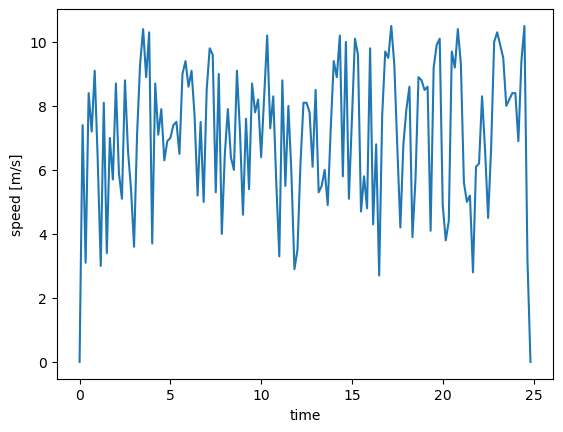

In [260]:
x_min = [x*dt/60 for x in range(0,len(times))]

#lr = m.getAttr("X", x)
plt.plot([k*dt/60 for k in list(lr.keys())],list(lr.values()))
#plt.plot(x_min,list(lr.values()))
plt.xlabel("time [minutes]")
plt.ylabel("speed [m/s]")
#plt.xticks(np.arange(0, 25.1, step=5))
plt.show()


In [9]:
#example of how to get attributes from solution vectors
u_fin = m.getAttr("X", u)
u_fin = list(u_fin.values())
u_fin = [round(el) for el in u_fin]
#print(u_fin)
#print(H)

#print(H)
#print(C*T)
#d = m.getAttr("LB", diff)
#print(d)

In [224]:
#example of how to get attributes from solution vectors
#x_fin = m.getAttr("X", b)
#x_fin = list(x_fin.values())
#x_fin = [round(el) for el in x_fin]
#print(x_fin)

parameters that can be referenced (defined higher up, specific values are subject to change)

### Input
dt = 10 #[s]; time step; divisible by 60; (dt | 60)

m_bike = 18.3 #[kg] mass of bike
m = 73.5 #mass of cyclist
mass = m + m_bike
weight = mass - m_bike
m is being used as the name of the model


level = "fit"



### Parameters
E_output = {"untrained": 1.5, "fit": 3.0, "highP": 5.0} #[W/kg]
P_max = m*E_output[level] #[W]

g = 9.81 # [m/s²]
RRcoef = 0.008 # [1]  % Rolling Resistance coefficient #####Changed!!! OK!
cw = 1 # [1]  
A = 0.5 # [m^2] % frontal area bike and cyclist
s = 0 #[rad] degree of slope
 
### Air density 
temp = 20 # [degree]
Temp = 273.15 + temp
rho = (10**(-5))*(Temp**2) - 0.0048*Temp + 1.2926 #which to use?



In [54]:
velocities = {0: 0.0, 1: 7.4, 2: 3.1, 3: 8.4, 4: 7.2, 5: 9.1, 6: 6.3, 7: 3.0, 8: 8.1, 9: 3.4, 10: 7.0, 11: 5.7, 12: 8.7, 13: 5.9, 14: 5.1, 15: 8.8, 16: 6.6, 17: 5.4, 18: 3.6, 19: 7.1, 20: 9.3, 21: 10.4, 22: 8.9, 23: 10.3, 24: 3.7, 25: 8.7, 26: 7.1, 27: 7.9, 28: 6.3, 29: 6.9, 30: 7.0, 31: 7.4, 32: 7.499999999994536, 33: 6.5, 34: 9.0, 35: 9.4, 36: 8.6, 37: 9.1, 38: 7.7, 39: 5.2, 40: 7.5, 41: 5.0, 42: 8.5, 43: 9.8, 44: 9.6, 45: 5.3, 46: 9.0, 47: 4.0, 48: 6.5, 49: 7.9, 50: 6.4, 51: 6.0, 52: 9.1, 53: 7.2, 54: 4.6, 55: 7.6, 56: 5.4, 57: 8.7, 58: 7.8, 59: 8.2, 60: 6.4, 61: 8.3, 62: 10.2, 63: 7.3, 64: 8.3, 65: 5.6, 66: 3.3, 67: 8.799985793996035, 68: 5.5, 69: 8.0, 70: 5.9, 71: 2.9000000000061887, 72: 3.5, 73: 6.2, 74: 8.1, 75: 8.1, 76: 7.8, 77: 6.1, 78: 8.5, 79: 5.3, 80: 5.5, 81: 6.0, 82: 4.9, 83: 7.3, 84: 9.4, 85: 8.9, 86: 10.2, 87: 5.8, 88: 10.0, 89: 5.1, 90: 7.6, 91: 10.1, 92: 9.6, 93: 4.7, 94: 5.8, 95: 4.8, 96: 9.8, 97: 4.3, 98: 6.8, 99: 2.7000358582605797, 100: 7.7, 101: 9.7, 102: 9.5, 103: 10.5, 104: 9.299999999999724, 105: 6.7, 106: 4.2, 107: 6.8, 108: 7.9, 109: 8.6, 110: 3.9, 111: 5.7, 112: 8.9, 113: 8.8, 114: 8.5, 115: 8.6, 116: 4.1, 117: 9.2, 118: 9.9, 119: 10.1, 120: 4.9, 121: 3.8, 122: 4.4, 123: 9.7, 124: 9.2, 125: 10.4, 126: 9.3, 127: 5.6, 128: 5.0, 129: 5.2, 130: 2.8, 131: 6.1, 132: 6.2, 133: 8.3, 134: 6.6, 135: 4.5, 136: 6.7, 137: 10.0, 138: 10.3, 139: 9.9, 140: 9.5, 141: 8.0, 142: 8.2, 143: 8.4, 144: 8.4, 145: 6.9, 146: 9.4, 147: 10.5, 148: 3.2, 149: 0.0}
weight = mass - m_bike

accel = []
prev_v = 0
v_mid = []
for time, vel in velocities.items():
    delta_v = vel - prev_v
    v_m = vel + prev_v
    
    prev_v = vel
    accel.append(delta_v/dt)
    v_mid.append(v_m/2)
    
#print(accel)
#print(v_mid)

def P_fun(acc, v):
    P_acc = acc*(mass)*v
    
    P_roll_steady = (mass) * g * RRcoef * v
    P_air_steady = 0.5 * cw * A * rho * (v**3)
    P_climb_steady = (mass)*g*s
    P_lost = P_roll_steady + P_air_steady + P_climb_steady
    
    P_used = P_acc + P_lost
    return max(0,P_used*dt)

    
    
P_list = []
E_list = []
for i in range(len(accel)):
    acc = accel[i]
    v = v_mid[i]
    P_used = P_fun(acc,v)
    P_list.append(P_used)
    E_list.append(P_used/weight)
    
    
E_int = []
tot_E = 0
for elem in E_list:
    tot_E += elem
    E_int += [tot_E]


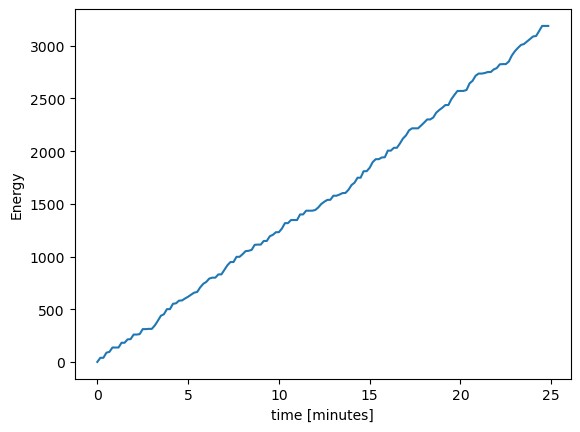

In [55]:
#lr = m.getAttr("X", x)
plt.plot([k*dt/60 for k in list(lr.keys())],E_int)
#plt.plot(x_min,list(lr.values()))
plt.xlabel("time [minutes]")
plt.ylabel("Energy")
#plt.xticks(np.arange(0, 25.1, step=5))
plt.show()


In [225]:
print(sum(H))

750.0


In [ ]:
H_round

## HEJ AMIS
jag hade caps lock inne
* du är bäst
* viktor är gullig

In [60]:
dft_vals

,vel_mean,acc_mean,dec_mean,idle,cruise,acc_time,vel_max,acc_max,dec_min
OPT,5.40,0.23,-0.26,0.08,0.35,0.33,14.02,1.07,-1.07
OG,5.43,0.22,-0.21,0.08,0.39,0.28,12.19,1.11,-1.06


In [92]:

list_trip = ["10131", "3722", "1388"]
for i in list_trip:
    df1 = pd.read_csv(i+"_trip.csv")
    df1.drop("Unnamed: 0", axis=1,inplace=True)

#create dataframe to keep track of unique values for all trips
    placeh = pd.DataFrame(index=["trip"+i])
    #add mean vel, mean acc, mean dec to each MT
    placeh["vel_mean"] = [df1["vel"].mean()]

    df1["pos_acc"] = df1["acc"]
    df1.loc[df1["pos_acc"] < 0 , "pos_acc"] = np.nan

    placeh["acc_mean"] = [df1["pos_acc"].mean()]


    df1["neg_acc"] = df1["acc"]
    df1.loc[df1["neg_acc"] > 0 , "neg_acc"] = np.nan


    placeh["dec_mean"] = [df1["neg_acc"].mean()]

    df1["idle"] = 0
    df1.loc[df1["vel"]<2, "idle"] = 1

    #add percentage of time spent idling
    placeh["idle"] = [df1["idle"].sum()/len(df1)]


    #(df1["stop"]*df1["time"]).groupby(level=0).sum()/df1["duration"].mean()

    #time spent cruising
    cruise_lim = 0.1 #[m/s^2]

    df1["cruise"] = 1
    df1.loc[df1["acc"] < -cruise_lim , "cruise"] = 0
    df1.loc[df1["acc"] > cruise_lim , "cruise"] = 0



    placeh["cruise"] = [df1["cruise"].sum()/len(df1)]

    #time spent accelerating
    cruise_lim = 0.1 #[m/s^2]

    df1["acc_time"] = 1
    df1.loc[df1["acc"] < cruise_lim , "acc_time"] = 0


    placeh["acc_time"] = [df1["acc_time"].sum()/len(df1)]

    placeh["vel_max"] = [df1["vel"].max()]
    placeh["acc_max"] = [df1["acc"].max()]
    placeh["dec_min"] = [df1["acc"].min()]

    for col in placeh.columns:
        placeh[col] = [round(x,2) for x in placeh[col].tolist()]
    #if no accel/decel takes place during a trip, this would be set to NaN, so here we just set those to zero

    dft_vals = pd.concat([dft_vals, placeh], ignore_index=False)

In [94]:
dft_vals.to_csv("char_param_sept23.csv")

In [97]:
test = pd.read_csv("OPT_trip.csv")

In [100]:
dft

,vel,acc,timesum,pos_acc,neg_acc,idle,cruise,acc_time
0,0.400,1.000,2,1.000,NaN,1,0,1
1,2.400,0.800,4,0.800,NaN,0,0,1
2,4.000,1.070,6,1.070,NaN,0,0,1
3,6.140,0.130,8,0.130,NaN,0,0,1
4,6.400,-0.400,10,NaN,-0.400,0,0,0
...,...,...,...,...,...,...,...,...
745,0.800,0.200,1492,0.200,NaN,1,0,1
746,1.200,0.061,1494,0.061,NaN,1,1,0
747,1.322,-0.261,1496,NaN,-0.261,1,0,0
748,0.800,-0.200,1498,NaN,-0.200,1,0,0
